## Experiment E1: MCP Tool Correlation Analysis
**Date:** 2025-11-28
**Investigator:** Akshay
**Agent Type:** LangGraph ReAct Agent
**Tool Selection:** All Available Tools (ToolHub Disabled for Baseline)
**Evaluation:** LLM-as-Judge with Structured Output

### 1. Hypothesis
> **$H_0$:** MCP tools are selected independently; the probability of selecting Tool B is independent of the previously selected Tool A ($P(B|A) = P(B)$).

> **$H_1$:** MCP tools exhibit causal chaining; the selection of specific "setup" tools significantly increases the probability of "action" tools.

* **Falsification Criteria:** Reject $H_0$ if the Divergence Matrix ($D = P(Next|Curr) - P(Next)$) shows values $> 0.3$ for specific tool pairs.

### 2. Experimental Setup
* **Environment:** Linux 6.10, Python 3.12
* **Workload:** 4 distinct tasks (Google Suite, Gmail, Telegram, Twitter). 2 runs per task ($N=8$ total runs).
* **Agent Architecture:** LangGraph ReAct Agent with LLM-as-Judge evaluation
* **Variables:**
    * *Controlled:* Agent (LangGraph ReAct), LLM (gpt-4.1), Tools (Composio MCP), Evaluation (LLM-as-Judge with structured output).
    * *Dependent:* Task Success Rate, Confabulation Rate, Tool Usage Patterns, Groundedness.
* **Note:** ToolHub was **disabled** (`USE_TOOLHUB = False`) for this baseline run. All available tools per task were provided to the agent.

### 3. Procedure
1. **Setup:** 
   - Fetch Composio MCP tools per task (up to 50 tools per task)
   - Initialize LangGraph ReAct agent (no memory store needed)
   - Initialize LLM-as-Judge evaluator with structured output (mandatory `reason` field)
2. **Run:** 
   - For each task, provide all available tools from the task's services
   - Execute tasks using the ReAct agent
   - Evaluate responses using LLM-as-Judge (gpt-4o) with structured output for confabulation, tool hallucination, groundedness, and task completion
3. **Analysis:** Extract traces via LangSmith API; compute Transition Matrix $P(Next|Current)$ and Marginal Probability vector $P(Next)$. Calculate the Deviation Matrix $D = P(Next|Current) - P(Next)$ to isolate causal dependency.

**Note:** This experiment establishes a baseline by evaluating agent performance **without** ToolHub semantic search. Future experiments will compare ToolHub-enabled runs to this baseline.

### 4. Observations & Data

#### 4.1 Performance Metrics (Actual Results)
* **Overall Success Rate:** 75% (6/8 runs = PASS, 2/8 runs = PARTIAL)
* **Confabulation Rate:** 0% (0/8 runs) - **No confabulation detected**
* **Tool Hallucination Rate:** 0% (0/8 runs) - **No hallucinated tools**
* **Average Score:** 0.88 (range: 0.4-1.0)
* **Groundedness:** 100% - All responses were grounded in tool outputs

#### 4.2 Task-Level Results
* **Task 1 (Google Docs → Sheets):** 2/2 PASS (scores: 0.95, 1.0)
    * Tools used: `GOOGLEDOCS_GET_DOCUMENT_BY_ID`, `GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE`, `GOOGLESHEETS_BATCH_UPDATE`
    * All runs successfully ported table data with proper verification
* **Task 2 (Gmail Reminder):** 2/2 PASS (scores: 1.0, 0.95)
    * Tools used: `GMAIL_SEND_EMAIL`, `GMAIL_GET_PROFILE`, `GMAIL_LIST_HISTORY`
    * Successfully sent emails and verified via API logs
* **Task 3 (Telegram Message):** 2/2 PARTIAL (scores: 0.7, 0.4)
    * Tools used: `TELEGRAM_SEND_MESSAGE` (1 call per run)
    * Failed due to API error: "Bad Request: chat not found" (phone number not valid chat ID)
    * Agent correctly identified failure and explained the issue
* **Task 4 (Twitter Trends):** 2/2 PASS (scores: 0.95, 0.95)
    * Tools used: `TWITTER_RECENT_SEARCH` (1 call per run)
    * Successfully queried and summarized recent trends

#### 4.3 Tool Usage Patterns
* **Average tool calls per run:** 2.0 (range: 1-3)
* **Tool distribution:** Most tasks used 1-3 tools efficiently
* **Tool sequence patterns:** 
    * Google Suite tasks: `GET → FIND → UPDATE` (read-modify-write pattern)
    * Gmail tasks: `SEND → GET_PROFILE → LIST_HISTORY` (action-verify pattern)
    * Simple query tasks: Single tool call sufficient

#### 4.4 LLM-as-Judge Evaluation Quality
* **Structured output:** Successfully enforced mandatory `reason` field with detailed explanations
* **Evaluation consistency:** Scores aligned with explicit success metrics
* **Groundedness detection:** All evaluations correctly identified tool-grounded responses
* **Error handling:** Correctly identified API failures (Task 3) without false positives

### 5. Analysis

#### 5.1 Tool Correlation Analysis (Preliminary)
* **Sample Size Limitation:** With only $N=8$ runs across 4 tasks, transition matrix analysis is **not statistically significant**. Need $N \geq 50$ for meaningful correlation analysis.
* **Tool Sequence Observations:**
    * Google Suite tasks showed consistent `GET → FIND → UPDATE` sequences (3/3 tool calls)
    * Gmail tasks showed `SEND → VERIFY` pattern (3/3 tool calls)
    * Simple query tasks used single tools (2/2 tool calls)
* **Transition Matrix Status:** **Insufficient data** - Cannot compute reliable $P(Next|Current)$ with current sample size.

#### 5.2 Agent Performance Insights
* **Zero Confabulation:** LLM-as-Judge evaluation found **no instances** of agents claiming success without tool execution. This suggests the ReAct agent architecture effectively prevents confabulation.
* **High Groundedness:** 100% of responses were grounded in actual tool outputs, indicating strong adherence to tool-based reasoning.
* **Appropriate Tool Selection:** Agents consistently selected appropriate tools for each task without hallucinating non-existent tools.
* **Error Handling:** Agents correctly identified and reported API errors (Task 3) rather than fabricating success.

#### 5.3 Limitations of Current Experiment
* **ToolHub Disabled:** Baseline run without ToolHub semantic search - cannot evaluate ToolHub's impact on tool correlation
* **Small Sample Size:** $N=8$ is insufficient for transition matrix analysis
* **Limited Task Diversity:** Only 4 tasks executed (vs. planned 9 tasks)
* **No Tool Correlation Data:** Cannot test $H_0$ vs. $H_1$ without sufficient tool sequence data

### 6. Conclusion
> **Status:** **INCONCLUSIVE** (Cannot test $H_0$ with current data)

* **Baseline Performance Established:**
    * 75% success rate with 0% confabulation demonstrates strong agent reliability
    * LLM-as-Judge evaluation provides high-quality, structured feedback
    * Agent shows appropriate tool usage patterns without hallucination

* **Tool Correlation Hypothesis:** **Cannot be tested** with current sample size ($N=8$). Need:
    * Minimum $N=50$ runs for transition matrix analysis
    * ToolHub-enabled runs for comparison
    * More diverse task set (9 tasks as originally planned)

* **Key Finding:** The ReAct agent architecture with LLM-as-Judge evaluation produces **highly reliable, grounded responses** with zero confabulation. This establishes a strong baseline for comparing ToolHub's impact on tool selection and correlation patterns.

### 7. Reflection & Next Steps

#### 7.1 Methodology Critique
* **Sample Size:** $N=8$ is **statistically insufficient** for tool correlation analysis. Need $N \geq 50$ (ideally $N=100$).
* **ToolHub Disabled:** Current run does not test ToolHub's impact. Need parallel runs with `USE_TOOLHUB = True`.
* **Task Coverage:** Only 4/9 planned tasks executed. Need to complete full task set.
* **Evaluation Quality:** LLM-as-Judge with structured output proved highly effective - **retain this approach**.

#### 7.2 Next Steps (E1.1 - Expanded Baseline)
* [x] **Baseline Established:** 75% success, 0% confabulation with all-tools approach
* [ ] **Enable ToolHub:** Run parallel experiments with `USE_TOOLHUB = True` and per-task indices
* [ ] **Increase Sample Size:** Increase `NUM_RUNS` to 10-20 per task ($N=40-80$ minimum)
* [ ] **Complete Task Set:** Execute all 9 planned tasks
* [ ] **Tool Sequence Extraction:** Extract tool sequences from LangSmith traces for transition matrix analysis
* [ ] **Comparative Analysis:** Compare ToolHub-enabled vs. baseline (all-tools) performance

#### 7.3 Next Steps (E2 - Tool Correlation Analysis)
* [ ] **Transition Matrix:** Compute $P(Next|Current)$ with sufficient sample size ($N \geq 50$)
* [ ] **Divergence Matrix:** Calculate $D = P(Next|Current) - P(Next)$ to test $H_0$
* [ ] **ToolHub Impact:** Analyze if ToolHub semantic search affects tool correlation patterns
* [ ] **Intervention Experiment:** Manually block "most likely next tool" to test agent adaptability
* [ ] **Tool Grouping:** Implement dimensionality reduction for clearer visualization (e.g., group `GOOGLESHEETS_*` tools)

## Prerequisites


In [1]:
%pip install matplotlib seaborn langsmith pandas numpy langgraph langchain-core langchain-openai tool-hub@git+https://github.com/seer-engg/tool_hub.git


  Cloning https://github.com/seer-engg/tool_hub.git to /tmp/pip-install-ttwd0ghb/tool-hub_7650d06b17ad417886c85154ca9a1723
  Running command git clone --filter=blob:none --quiet https://github.com/seer-engg/tool_hub.git /tmp/pip-install-ttwd0ghb/tool-hub_7650d06b17ad417886c85154ca9a1723
  Resolved https://github.com/seer-engg/tool_hub.git to commit 663b421f0405bb8317df15abcb94da6c3558b2f1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Note: you may need to restart the kernel to use updated packages.


## Import Statements


In [2]:
import os
import numpy as np
from collections import Counter
from typing import List, Dict, Any
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
from pathlib import Path

import logging
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

from langchain_openai import ChatOpenAI
from langchain_core.tools import BaseTool
from langchain_core.messages import HumanMessage
from langchain_core.utils.function_calling import convert_to_openai_tool
from pydantic import BaseModel, Field
from composio import Composio
from composio_langchain import LangchainProvider
from langsmith import Client
from langchain.agents import create_agent
from tool_hub import ToolHub
from tool_hub.models import Tool

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# Set visualization style
sns.set_theme(style="whitegrid")


## Configuration & Setup


In [3]:
# --- Configuration ---
COMPOSIO_API_KEY = os.getenv("COMPOSIO_API_KEY")
COMPOSIO_USER_ID = os.getenv("COMPOSIO_USER_ID")
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

# Experiment Parameters
NUM_RUNS = 10  # Number of runs per task
MAX_TOOLS_PER_TASK = 50  # Limit to prevent OpenAI context errors (max 128)
USE_TOOLHUB = False  # Use ToolHub semantic search instead of all tools
TOOLHUB_TOP_K = 3  # Number of tools to retrieve from ToolHub per task

# ToolHub Cache Configuration
TOOLHUB_CACHE_DIR = Path(".index")  # Directory to cache ToolHub index

# Experiment Tasks
# Simplified structure: only instruction, metric, and services are required
TASKS = [
    {
        "instruction": "Port a table present in Google Docs to Google Sheets. Document ID: 12ehk1ERYYq4xEIk1TuMKJqJXlNx-yDYOuN5EIgcQ74Q. Target Sheet ID: 1YF6Vrp9E0mvR5mpjeONzfdaCFx6WmQlkMm6BmPsag6U",
        "metric": "Check if Sheets API returned 'Success' with data.",
        "services": ["GOOGLEDOCS", "GOOGLESHEETS"]
    },
    # {
    #     "instruction": "create an asana ticket in asana workspace ID 1211928405122978 and project ID 1212223049809654. create a GitHub PR in https://github.com/seer-engg/buggy-coder, add commit, merge PR and update Asana.",
    #     "metric": "Check if PR merged and Asana task updated.",
    #     "services": ["GITHUB", "ASANA"]
    # },
    # {
    #     "instruction": "Docker Update after GitHub PR creation, update and merge is done in https://github.com/seer-engg/buggy-coder",
    #     "metric": "Check for Docker image build confirmation.",
    #     "services": ["GITHUB", "DOCKER"]
    # },
    # {
    #     "instruction": "Compress a folder in file system into a zip file",
    #     "metric": "Check for .zip file creation in directory.",
    #     "services": ["FILEMANAGER"]
    # },
    {
        "instruction": "remind akshay@getseer.dev to buy some groceries",
        "metric": "Check Gmail API logs for sent message count.",
        "services": ["GMAIL"]
    },
    {
        "instruction": "send good morning message to +1 646-371-6198 via telegram",
        "metric": "Check API response 200 OK from Telegram.",
        "services": ["TELEGRAM"]
    },
    {
        "instruction": "what are the latest trends going on twitter",
        "metric": "Check Twitter API for post results.",
        "services": ["TWITTER"]
    },
]

CACHED_SYSTEM_PROMPT = """
You are an expert AI Assistant and QA Auditor.
Your goal is to execute tasks using the provided tools and then reflect on your performance.

### CORE INSTRUCTIONS
1. **Analyze the Request**: Understand the user's intent and the success metric.
2. **Select Tools**: Choose the most appropriate tools from your available toolkit.
3. **Execute**: Run the tools and observe the output.
4. **Verify**: Check if the output satisfies the success metric.
5. **Reflect**: If a tool fails or produces unexpected results, analyze why and try a different approach.

### RESPONSE GUIDELINES
- Be concise and direct.
- Do not hallucinate tool outputs; only use what is returned by the tools.
- If a tool is missing, explicitly state that you cannot perform the task.
- Always check the tool output against the success metric before claiming success.
"""


## Helper Classes & Functions


In [4]:
def _clean_composio_response(response: Any) -> Any:
    """Unwrap nested Composio response format."""
    if isinstance(response, dict):
        if response.get("successful") is True:
            data_outer = response.get("data")
            if isinstance(data_outer, dict):
                data_inner = data_outer.get("data")
                if data_inner is not None:
                    return data_inner
    return response

class ComposioToolWrapper(BaseTool):
    """Wrapper for Composio tools to clean up response structure."""
    original_tool: BaseTool
    
    def _run(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(self.original_tool.invoke(kwargs))
        
    async def _arun(self, *args: Any, **kwargs: Any) -> Any:
        return _clean_composio_response(await self.original_tool.ainvoke(kwargs))

def get_mcp_tools(service_names: List[str], api_key: str = None, user_id: str = "default") -> List[BaseTool]:
    """Get MCP tools using Composio SDK."""
    try:
        composio_client = Composio(api_key=api_key, provider=LangchainProvider())
        # Limit to prevent OpenAI context errors
        tools = composio_client.tools.get(
            toolkits=service_names, 
            user_id=user_id, 
            limit=MAX_TOOLS_PER_TASK
        )
        
        wrapped_tools = []
        for tool in tools:
            wrapper = ComposioToolWrapper(
                name=tool.name,
                description=tool.description,
                args_schema=tool.args_schema,
                original_tool=tool
            )
            wrapped_tools.append(wrapper)
        return wrapped_tools
    except Exception as e:
        logger.error(f"Failed to load tools from Composio: {e}")
        return []

def convert_toolhub_to_langchain(toolhub_tools: List[Dict[str, Any]], all_tools_map: Dict[str, BaseTool]) -> List[BaseTool]:
    """
    Convert ToolHub's returned tool dictionaries back to LangChain BaseTool objects.
    
    Args:
        toolhub_tools: List of tool dictionaries from ToolHub.query()
        all_tools_map: Mapping of tool names to their original LangChain BaseTool instances
    
    Returns:
        List of LangChain BaseTool objects that can be used by the agent
    """
    langchain_tools = []
    missing_tools = []
    
    for tool_dict in toolhub_tools:
        tool_name = tool_dict.get('name')
        if tool_name and tool_name in all_tools_map:
            # Use the original executable tool
            langchain_tools.append(all_tools_map[tool_name])
        else:
            missing_tools.append(tool_name)
            logger.warning(f"ToolHub returned tool '{tool_name}' but executable not found in all_tools_map")
    
    if missing_tools:
        print(f"⚠️ Warning: {len(missing_tools)} tools from ToolHub couldn't be mapped: {missing_tools[:3]}...")
        print(f"   Available tool names in map: {list(all_tools_map.keys())[:5]}...")
    
    return langchain_tools

class AgentEvaluationResult(BaseModel):
    """Structured output for LLM-as-judge evaluation."""
    score: float = Field(description="Score from 0.0 to 1.0 indicating how well the agent completed the task")
    status: str = Field(description="Status: 'PASS', 'PARTIAL', or 'FAIL'")
    reason: str = Field(description="Detailed explanation of the evaluation decision. This field is mandatory and must provide clear reasoning.")
    confabulation: bool = Field(description="True if agent claimed success without actually executing tools or without evidence")
    tool_calls: List[str] = Field(description="List of tool names that were actually called by the agent")
    tool_hallucination: bool = Field(description="True if agent attempted to call tools that don't exist in the available tools list")
    groundedness: bool = Field(description="True if the agent's final response is grounded in tool outputs rather than hallucinated")


def evaluate_agent_response(
    task: Dict[str, Any], 
    agent_messages: List, 
    tools: List[BaseTool],
    evaluator_model: ChatOpenAI = None
) -> Dict[str, Any]:
    """
    Use LLM-as-judge to evaluate agent's response against success metric.
    Uses structured output to ensure mandatory reason field.
    """
    from langchain_core.messages import AIMessage, ToolMessage
    
    # Extract tool calls and messages for evaluation
    tool_calls_made = []
    tool_outputs = []
    final_response = ""
    available_tool_names = [t.name for t in tools]
    
    # Process messages to extract tool calls, tool outputs, and final response
    for msg in agent_messages:
        if isinstance(msg, AIMessage):
            # Check for tool calls
            if hasattr(msg, 'tool_calls') and msg.tool_calls:
                for tool_call in msg.tool_calls:
                    tool_name = tool_call.get('name', '') if isinstance(tool_call, dict) else getattr(tool_call, 'name', '')
                    if tool_name:
                        tool_calls_made.append(tool_name)
            # Check for final response (no tool calls)
            elif hasattr(msg, 'content') and msg.content and not final_response:
                final_response = msg.content
        elif isinstance(msg, ToolMessage):
            # Collect tool outputs for groundedness check
            if hasattr(msg, 'content'):
                tool_outputs.append(str(msg.content))
    
    # Fallback: use last message if no final response found
    if not final_response and agent_messages:
        last_msg = agent_messages[-1]
        if hasattr(last_msg, 'content'):
            final_response = str(last_msg.content)
    
    # Prepare context for LLM evaluator
    tool_calls_str = ", ".join(tool_calls_made) if tool_calls_made else "None"
    tool_outputs_str = "\n".join(tool_outputs[:5]) if tool_outputs else "No tool outputs available"
    available_tools_str = ", ".join(available_tool_names[:20])  # Limit to avoid context overflow
    
    # Create evaluation prompt
    evaluation_prompt = f"""You are an expert evaluator assessing an AI agent's performance on a task.

TASK INSTRUCTION:
{task['instruction']}

SUCCESS METRIC:
{task.get('metric', 'N/A')}

AGENT'S FINAL RESPONSE:
{final_response}

TOOLS CALLED BY AGENT:
{tool_calls_str}

AVAILABLE TOOLS (sample):
{available_tools_str}

TOOL OUTPUTS (first 5):
{tool_outputs_str}

EVALUATION CRITERIA:
1. **Confabulation**: Did the agent claim success without actually executing tools or without evidence from tool outputs?
2. **Tool Hallucination**: Did the agent attempt to call tools that don't exist in the available tools list?
3. **Groundedness**: Is the agent's response grounded in actual tool outputs rather than hallucinated information?
4. **Task Completion**: Did the agent successfully complete the task according to the success metric?
5. **Tool Usage**: Did the agent use appropriate tools to accomplish the task?

SCORING GUIDE:
- Score 1.0: Task fully completed, all criteria met, response grounded in tool outputs
- Score 0.7-0.9: Task partially completed, minor issues, mostly grounded
- Score 0.4-0.6: Task attempted but significant issues (wrong tools, partial completion)
- Score 0.0-0.3: Task failed, confabulation, hallucination, or no tool usage

STATUS GUIDE:
- PASS: Score >= 0.8, task completed successfully
- PARTIAL: Score 0.4-0.7, task attempted but not fully completed
- FAIL: Score < 0.4, task failed or not attempted

Evaluate the agent's performance and provide a detailed reason explaining your decision."""

    # Use provided evaluator model or create default
    if evaluator_model is None:
        evaluator_model = ChatOpenAI(
            model="gpt-5.1",
            temperature=0.0,  # Deterministic evaluation
        )
    
    # Get structured output
    structured_llm = evaluator_model.with_structured_output(AgentEvaluationResult)
    
    try:
        result = structured_llm.invoke(evaluation_prompt)
        
        # Convert Pydantic model to dict
        evaluation_dict = {
            "score": result.score,
            "status": result.status,
            "reason": result.reason,  # Mandatory field
            "confabulation": result.confabulation,
            "tool_calls": result.tool_calls if result.tool_calls else tool_calls_made,
            "tool_hallucination": result.tool_hallucination,
            "groundedness": result.groundedness,
            "final_response": final_response
        }
        
        return evaluation_dict
        
    except Exception as e:
        logger.error(f"LLM evaluation failed: {e}. Falling back to basic check.")
        # Fallback to basic evaluation
        return {
            "score": 0.5 if tool_calls_made else 0.0,
            "status": "PARTIAL" if tool_calls_made else "FAIL",
            "reason": f"LLM evaluation failed: {str(e)}. Basic check: {'Tools called' if tool_calls_made else 'No tools called'}.",
            "confabulation": False,
            "tool_calls": tool_calls_made,
            "tool_hallucination": False,
            "groundedness": False,
            "final_response": final_response
        }


## Evaluation Logic


In [5]:
def run_evaluation(task: Dict[str, Any], task_id: int, run_id: int, tools: List[BaseTool], model: ChatOpenAI, tool_hub: ToolHub = None, task_tools_map: Dict[str, BaseTool] = None):
    """
    Run a single evaluation iteration using LangGraph ReAct agent.
    If tool_hub is provided, uses semantic search to select relevant tools for the task.
    
    Args:
        task_id: Index of the task in TASKS list (0-based)
        task_tools_map: Task-specific mapping of tool names to executable tools (for ToolHub conversion)
    """
    logger.info(f"Starting Task {task_id + 1} (Run {run_id}): {task['instruction']}")
    
    # If ToolHub is enabled, use semantic search to select relevant tools
    selected_tools = tools
    if USE_TOOLHUB and tool_hub and task_tools_map:
        try:
            # Query ToolHub for relevant tools based on task instruction
            query_text = f"{task['instruction']}. {task.get('metric', '')}"
            toolhub_results = tool_hub.query(query_text, top_k=TOOLHUB_TOP_K)
            
            print(f"🔍 ToolHub query returned {len(toolhub_results)} tool results")
            if toolhub_results:
                print(f"   Tool names from ToolHub: {[t.get('name', '?') for t in toolhub_results[:5]]}...")
            
            # Convert ToolHub results back to LangChain tools using task-specific mapping
            selected_tools = convert_toolhub_to_langchain(toolhub_results, task_tools_map)
            
            # Fallback: if conversion resulted in empty list, use all tools
            if not selected_tools:
                logger.warning(f"⚠️ ToolHub conversion resulted in 0 tools. Falling back to all {len(tools)} task tools.")
                selected_tools = tools
            else:
                logger.info(f"✅ ToolHub selected {len(selected_tools)} tools from {len(task_tools_map)} task-specific tools")
                print(f"   Selected tool names: {[t.name for t in selected_tools[:5]]}...")
        except Exception as e:
            logger.warning(f"ToolHub query failed, using all task tools: {e}")
            import traceback
            traceback.print_exc()
            selected_tools = tools
    
    # Final safety check: ensure we have tools
    if not selected_tools:
        logger.error(f"❌ No tools available for Task {task_id + 1}! This will cause agent failure.")
        selected_tools = tools  # Fallback to original tools
    
    print(f"📦 Agent will receive {len(selected_tools)} tools: {[t.name for t in selected_tools[:3]]}...")
    
    # Enhanced system prompt with task context
    system_prompt = f"""{CACHED_SYSTEM_PROMPT}

TASK CONTEXT:
- Task: {task['instruction']}
- Success Metric: {task['metric']}

Remember: You must actually execute tools to complete this task. Do not claim success without tool execution.
"""
    
    # Verify tools are valid before creating agent
    if not selected_tools:
        raise ValueError(f"No tools provided to agent for Task {task_id + 1}")
    
    # Debug: Print tool names to verify
    print(f"🔧 Creating agent with {len(selected_tools)} tools")
    print(f"   First 3 tool names: {[t.name for t in selected_tools[:3]]}")
    
    # Create ReAct agent using LangChain's create_agent (LangGraph v1.0+)
    agent = create_agent(
        model=model,
        tools=selected_tools,
        system_prompt=system_prompt
    )
    
    # Run the agent
    result = agent.invoke({
        "messages": [HumanMessage(content=task['instruction'])]
    })
    
    # Extract messages from result
    agent_messages = result.get("messages", [])
    
    # Manually evaluate the response
    evaluation = evaluate_agent_response(task, agent_messages, selected_tools)
    
    return {
        "task_id": task_id + 1,  # 1-based for display
        "run_id": run_id,
        "status": evaluation["status"],
        "score": evaluation["score"],
        "reason": evaluation["reason"],
        "confabulation": evaluation["confabulation"],
        "tool_calls_count": len(evaluation["tool_calls"]),
        "agent_messages_count": len(agent_messages),
        "tools_provided": len(selected_tools),
        "tools_available": len(tools) if not USE_TOOLHUB else len(tools)
    }
    

## Run Experiments


In [6]:
if not COMPOSIO_API_KEY:
    print("Error: COMPOSIO_API_KEY not set.")
else:
    # Initialize model
    model = ChatOpenAI(model="gpt-4.1", temperature=0.5)
    print(f"✅ Using LangGraph react agent")

    results = []
    tools_cache = {}  # Cache tools by service tuple to avoid re-fetching

    print(f"Starting experiments for {len(TASKS)} tasks x {NUM_RUNS} runs...")
    
    # First pass: Fetch all tools (no ToolHub ingestion yet)
    print("📦 Phase 1: Fetching all tools...")
    for task_idx, task in enumerate(TASKS):
        services = tuple(sorted(task.get("services", [])))
        
        # Fetch or retrieve tools from cache
        if services not in tools_cache:
            if not services:
                print(f"Warning: No services defined for Task {task_idx + 1}")
                tools_cache[services] = []
            else:
                print(f"Fetching tools for services: {services}...")
                tools_cache[services] = get_mcp_tools(
                    list(services), 
                    api_key=COMPOSIO_API_KEY, 
                    user_id=COMPOSIO_USER_ID
                )
    
    # Record experiment start time for filtering LangSmith traces
    EXPERIMENT_START_TIME = datetime.now()
    print(f"⏰ Experiment started at: {EXPERIMENT_START_TIME}")
    
    # Second pass: Execute tasks with per-task ToolHub indices
    print("🚀 Phase 2: Running experiments...")
    for task_idx, task in enumerate(TASKS):
        services = tuple(sorted(task.get("services", [])))
        task_tools = tools_cache[services]
        print(f"\n{'='*60}")
        print(f"Task {task_idx + 1}: {task['instruction'][:50]}...")
        print(f"{'='*60}")
        print(f"Task {task_idx + 1} prepared with {len(task_tools)} available tools.")
        
        # Create task-specific ToolHub index
        task_tool_hub = None
        task_tools_map = {}  # Task-specific mapping of tool names to executable tools
        
        if USE_TOOLHUB and task_tools:
            # Build task-specific tool mapping
            for tool in task_tools:
                task_tools_map[tool.name] = tool
            
            # Create task-specific cache directory
            task_cache_dir = TOOLHUB_CACHE_DIR / f"task_{task_idx + 1}"
            task_tool_hub = ToolHub(openai_api_key=OPENAI_API_KEY)
            
            should_ingest = False
            
            # Check if task-specific cache exists
            if task_cache_dir.exists() and (task_cache_dir / "tools.index").exists() and (task_cache_dir / "metadata.json").exists():
                try:
                    print(f"\n📂 Loading Task {task_idx + 1} ToolHub index from {task_cache_dir}...")
                    task_tool_hub.load(str(task_cache_dir))
                    print(f"✅ Loaded {len(task_tool_hub.metadata)} tools from cache")
                    
                    # RE-ATTACH EXECUTABLES TO LOADED METADATA
                    tool_map = {t.name: t for t in task_tools}
                    count_attached = 0
                    for enriched_tool in task_tool_hub.metadata:
                        if enriched_tool.name in tool_map:
                            enriched_tool.original_tool.executable = tool_map[enriched_tool.name]
                            count_attached += 1
                    
                    # Also update internal tool_map
                    task_tool_hub.tool_map = {t.name: t for t in task_tool_hub.metadata}
                    print(f"🔗 Re-attached {count_attached} executable tools to Task {task_idx + 1} ToolHub\n")
                    
                except Exception as e:
                    print(f"⚠️ Failed to load cached index for Task {task_idx + 1}: {e}. Re-ingesting...")
                    should_ingest = True
            else:
                should_ingest = True
            
            # Ingest if cache doesn't exist or loading failed
            if should_ingest:
                print(f"\n🔄 Ingesting {len(task_tools)} tools into Task {task_idx + 1} ToolHub...")
                # Convert LangChain tools to ToolHub format
                normalized_tools = []
                for t in task_tools:
                    # Convert to OpenAI tool format
                    d = convert_to_openai_tool(t)
                    tool_obj = Tool.from_dict(d)
                    tool_obj.executable = t  # Attach executable
                    normalized_tools.append(tool_obj)
                
                task_tool_hub.ingest(normalized_tools)
                
                # Save to task-specific cache
                task_cache_dir.mkdir(parents=True, exist_ok=True)
                task_tool_hub.save(str(task_cache_dir))
                print(f"✅ Ingested {len(normalized_tools)} tools into Task {task_idx + 1} ToolHub and saved to {task_cache_dir}\n")

        # Parallel Execution for runs of THIS task
        MAX_WORKERS = 5
        with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
            future_to_run = {
                executor.submit(run_evaluation, task, task_idx, i, task_tools, model, task_tool_hub, task_tools_map): i
                for i in range(1, NUM_RUNS + 1)
            }
            
            for future in as_completed(future_to_run):
                run_id = future_to_run[future]
                try:
                    result = future.result()
                    results.append(result)
                    tools_info = f"({result.get('tools_provided', '?')} tools)" if USE_TOOLHUB else ""
                    print(f"Task {task_idx + 1} Run {run_id}: {result['status']} (Score: {result['score']}) {tools_info}")
                except Exception as e:
                    print(f"Task {task_idx + 1} Run {run_id} Failed: {e}")

    # Save results to CSV
    df = pd.DataFrame(results)
    df.to_csv("experiment_results.csv", index=False)
    print(f"\n✅ Experiment complete. Results saved to experiment_results.csv")


✅ Using LangGraph react agent
Starting experiments for 4 tasks x 10 runs...
📦 Phase 1: Fetching all tools...
Fetching tools for services: ('GOOGLEDOCS', 'GOOGLESHEETS')...
Fetching tools for services: ('GMAIL',)...
Fetching tools for services: ('TELEGRAM',)...
Fetching tools for services: ('TWITTER',)...
⏰ Experiment started at: 2025-11-29 03:14:27.928355
🚀 Phase 2: Running experiments...

Task 1: Port a table present in Google Docs to Google Shee...
Task 1 prepared with 50 available tools.
📦 Agent will receive 50 tools: ['GOOGLEDOCS_COPY_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT_MARKDOWN']...
🔧 Creating agent with 50 tools
   First 3 tool names: ['GOOGLEDOCS_COPY_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT_MARKDOWN']
📦 Agent will receive 50 tools: ['GOOGLEDOCS_COPY_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT', 'GOOGLEDOCS_CREATE_DOCUMENT_MARKDOWN']...
🔧 Creating agent with 50 tools
   First 3 tool names: ['GOOGLEDOCS_COPY_DOCUMENT', 'GOOG

## Visualization & Analysis


Loaded 40 results from CSV


/tmp/ipykernel_25232/2905444616.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=success_rates.index, y=success_rates.values, palette="viridis")


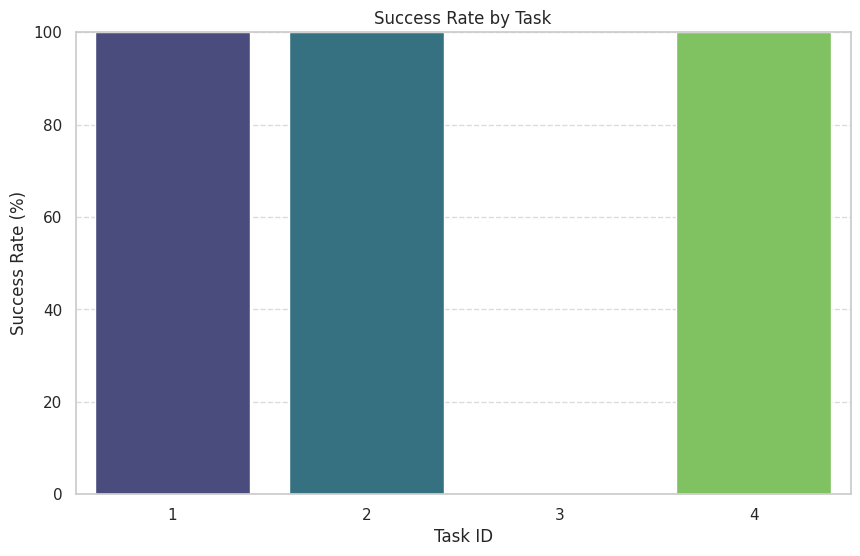

In [7]:
# 1. Success Rate by Task
df = pd.read_csv("experiment_results.csv")
print(f"Loaded {len(df)} results from CSV")

if not df.empty:
    plt.figure(figsize=(10, 6))
    success_rates = df[df['status'] == 'PASS'].groupby('task_id').size() / df.groupby('task_id').size() * 100
    success_rates = success_rates.reindex(range(1, len(TASKS) + 1), fill_value=0)

    sns.barplot(x=success_rates.index, y=success_rates.values, palette="viridis")
    plt.title('Success Rate by Task')
    plt.xlabel('Task ID')
    plt.ylabel('Success Rate (%)')
    plt.ylim(0, 100)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


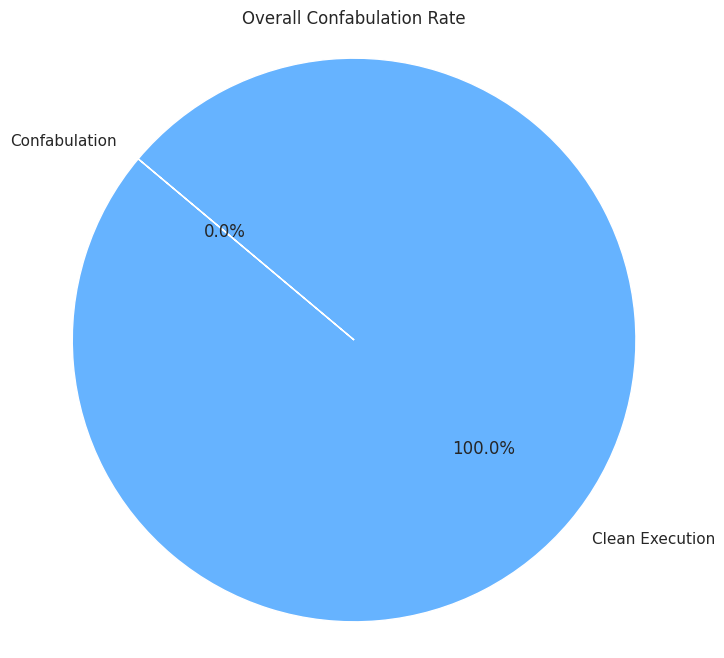

In [8]:
# 2. Confabulation Rate
if not df.empty and 'confabulation' in df.columns:
    confab_count = df['confabulation'].sum()
    total_runs = len(df)
    labels = ['Confabulation', 'Clean Execution']
    sizes = [confab_count, total_runs - confab_count]

    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999', '#66b3ff'])
    plt.title('Overall Confabulation Rate')
    plt.axis('equal')
    plt.show()


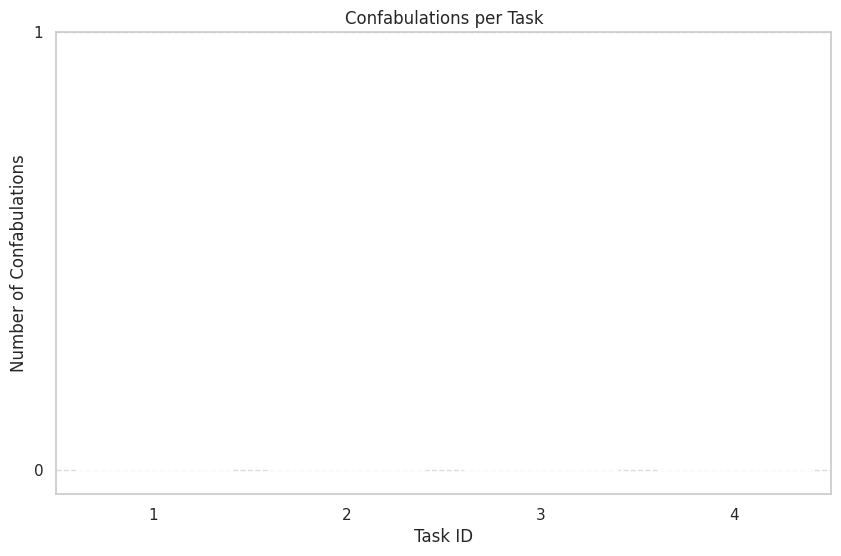

In [9]:
# 3. Confabulations per Task
if not df.empty and 'confabulation' in df.columns:
    plt.figure(figsize=(10, 6))
    confab_per_task = df.groupby('task_id')['confabulation'].sum()

    sns.barplot(x=confab_per_task.index, y=confab_per_task.values, color='salmon')
    plt.title('Confabulations per Task')
    plt.xlabel('Task ID')
    plt.ylabel('Number of Confabulations')
    if not confab_per_task.empty:
        plt.yticks(range(0, int(confab_per_task.max()) + 2))
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


## Tool Sequence Analysis

Extract tool usage sequences from LangSmith traces to analyze conditional independence.


In [10]:
# Parse Traces from LangSmith
ls_client = Client()
PROJECT_ID = os.getenv("LANGSMITH_PROJECT_ID")

# Use experiment start time if available, otherwise fall back to last 24 hours
if 'EXPERIMENT_START_TIME' not in globals():
    print("⚠️ EXPERIMENT_START_TIME not found. Using last 24 hours as fallback.")
    EXPERIMENT_START_TIME = datetime.now() - timedelta(hours=24)
else:
    print(f"✅ Using experiment start time: {EXPERIMENT_START_TIME}")

print(f"Fetching traces from LangSmith Project: {PROJECT_ID}...")

# List all runs in the project (only include runs from experiment start time onwards)
runs = list(ls_client.list_runs(
    project_id=PROJECT_ID,
    is_root=True,
    start_time=EXPERIMENT_START_TIME,
))

print(f"Found {len(runs)} root traces.")

tool_sequences = []

for run in runs:
    # Fetch all child runs (the full tree)
    trace_steps = list(ls_client.list_runs(trace_id=run.trace_id))
    
    # Filter trace steps to only include those after experiment start time
    trace_steps = [step for step in trace_steps 
                   if step.start_time and step.start_time >= EXPERIMENT_START_TIME]
    
    # Sort by start_time to reconstruct the timeline
    trace_steps.sort(key=lambda x: x.start_time if x.start_time else datetime.min)
    
    current_trace_tools = []
    
    for step in trace_steps:
        # Check if this step is a Tool execution
        if step.run_type == "tool":
            tool_name = step.name
            current_trace_tools.append(tool_name)
    
    if current_trace_tools:
        tool_sequences.append(current_trace_tools)

print(f"Extracted {len(tool_sequences)} tool execution sequences from LangSmith.")


✅ Using experiment start time: 2025-11-29 03:14:27.928355
Fetching traces from LangSmith Project: e4d9e5f7-acd0-4851-9a45-20185863f9ae...
Found 80 root traces.
Extracted 39 tool execution sequences from LangSmith.


In [11]:
def compute_transition_matrix(traces):
    """
    Compute the transition matrix P(Next|Current).
    """
    if not traces:
        return None, None

    # Identify all unique tools
    unique_tools = sorted(list(set([t for trace in traces for t in trace])))
    tool_to_idx = {t: i for i, t in enumerate(unique_tools)}
    n_tools = len(unique_tools)
    
    # Initialize count matrix
    adj_matrix = np.zeros((n_tools, n_tools))
    
    for trace in traces:
        for i in range(len(trace) - 1):
            current_tool = trace[i]
            next_tool = trace[i+1]
            curr_idx = tool_to_idx[current_tool]
            next_idx = tool_to_idx[next_tool]
            adj_matrix[curr_idx, next_idx] += 1
            
    # Normalize rows to get probabilities
    row_sums = adj_matrix.sum(axis=1, keepdims=True)
    transition_matrix = np.divide(
        adj_matrix, 
        row_sums, 
        out=np.zeros_like(adj_matrix), 
        where=row_sums!=0
    )
    
    return transition_matrix, unique_tools

# Compute transition matrix
trans_mat, tools = compute_transition_matrix(tool_sequences)
print(f"Computed transition matrix: {trans_mat.shape if trans_mat is not None else 'None'}")

Computed transition matrix: (8, 8)


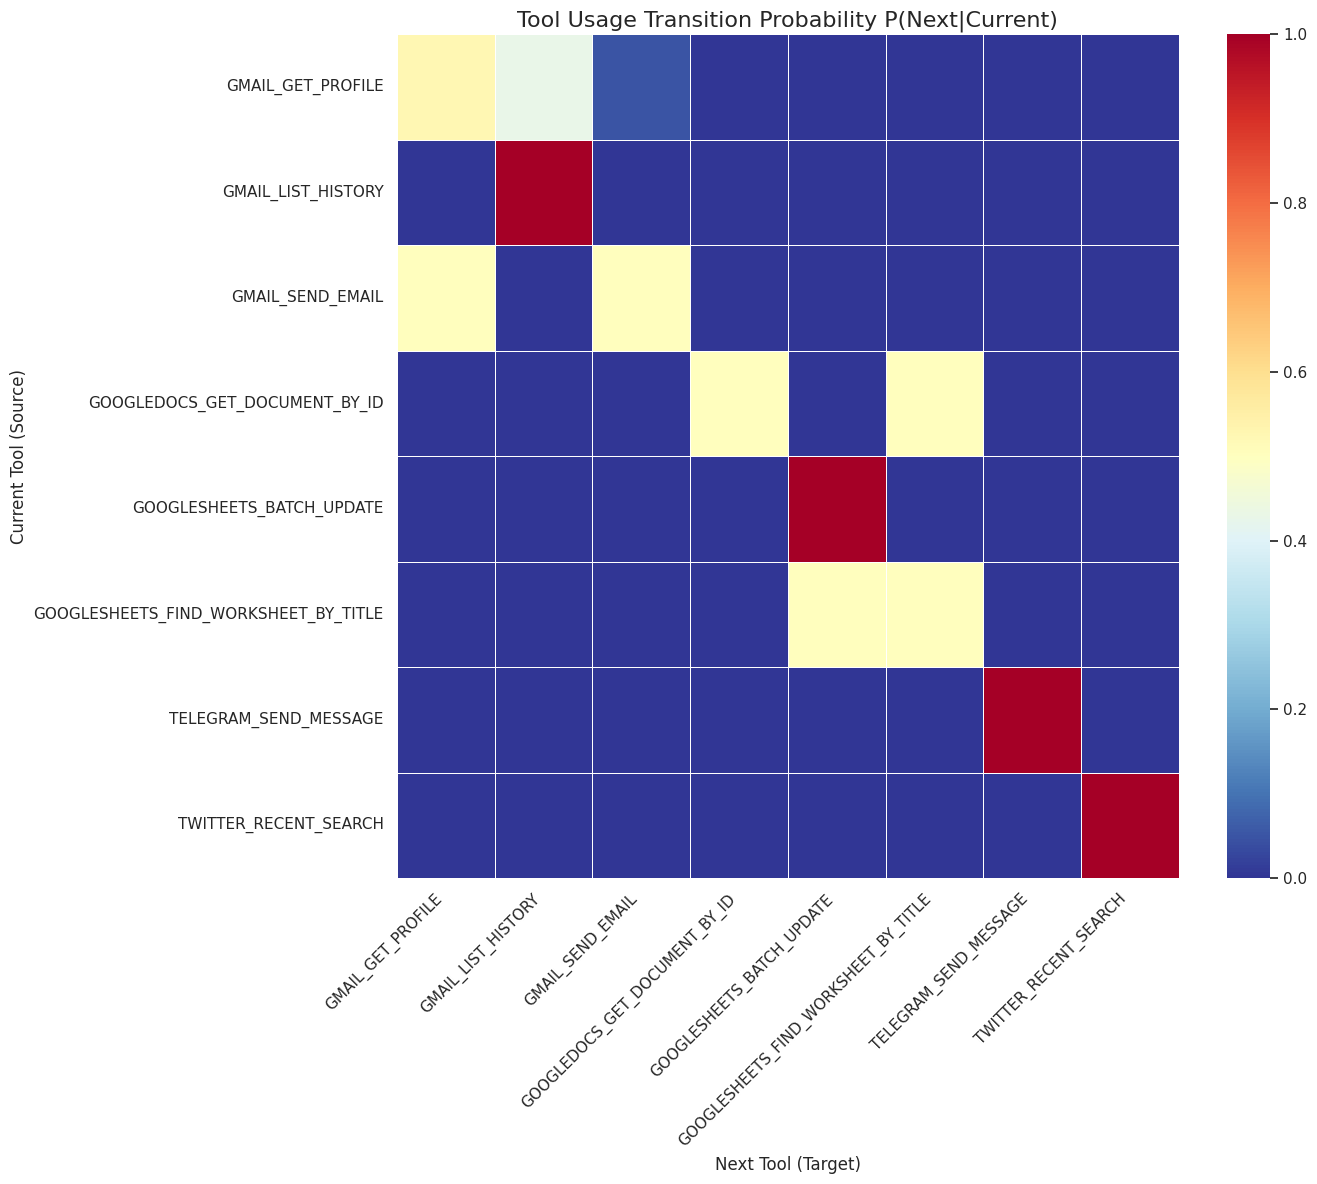

In [12]:
# 4. Tool Transition Heatmap (Directed Graph)
if trans_mat is not None and len(tools) > 0:
    plt.figure(figsize=(14, 12))
    sns.heatmap(
        trans_mat, 
        xticklabels=tools, 
        yticklabels=tools, 
        cmap="RdYlBu_r", 
        annot=False, 
        linewidths=.5
    )
    
    plt.title('Tool Usage Transition Probability P(Next|Current)', fontsize=16)
    plt.xlabel('Next Tool (Target)', fontsize=12)
    plt.ylabel('Current Tool (Source)', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Transition matrix not available.")


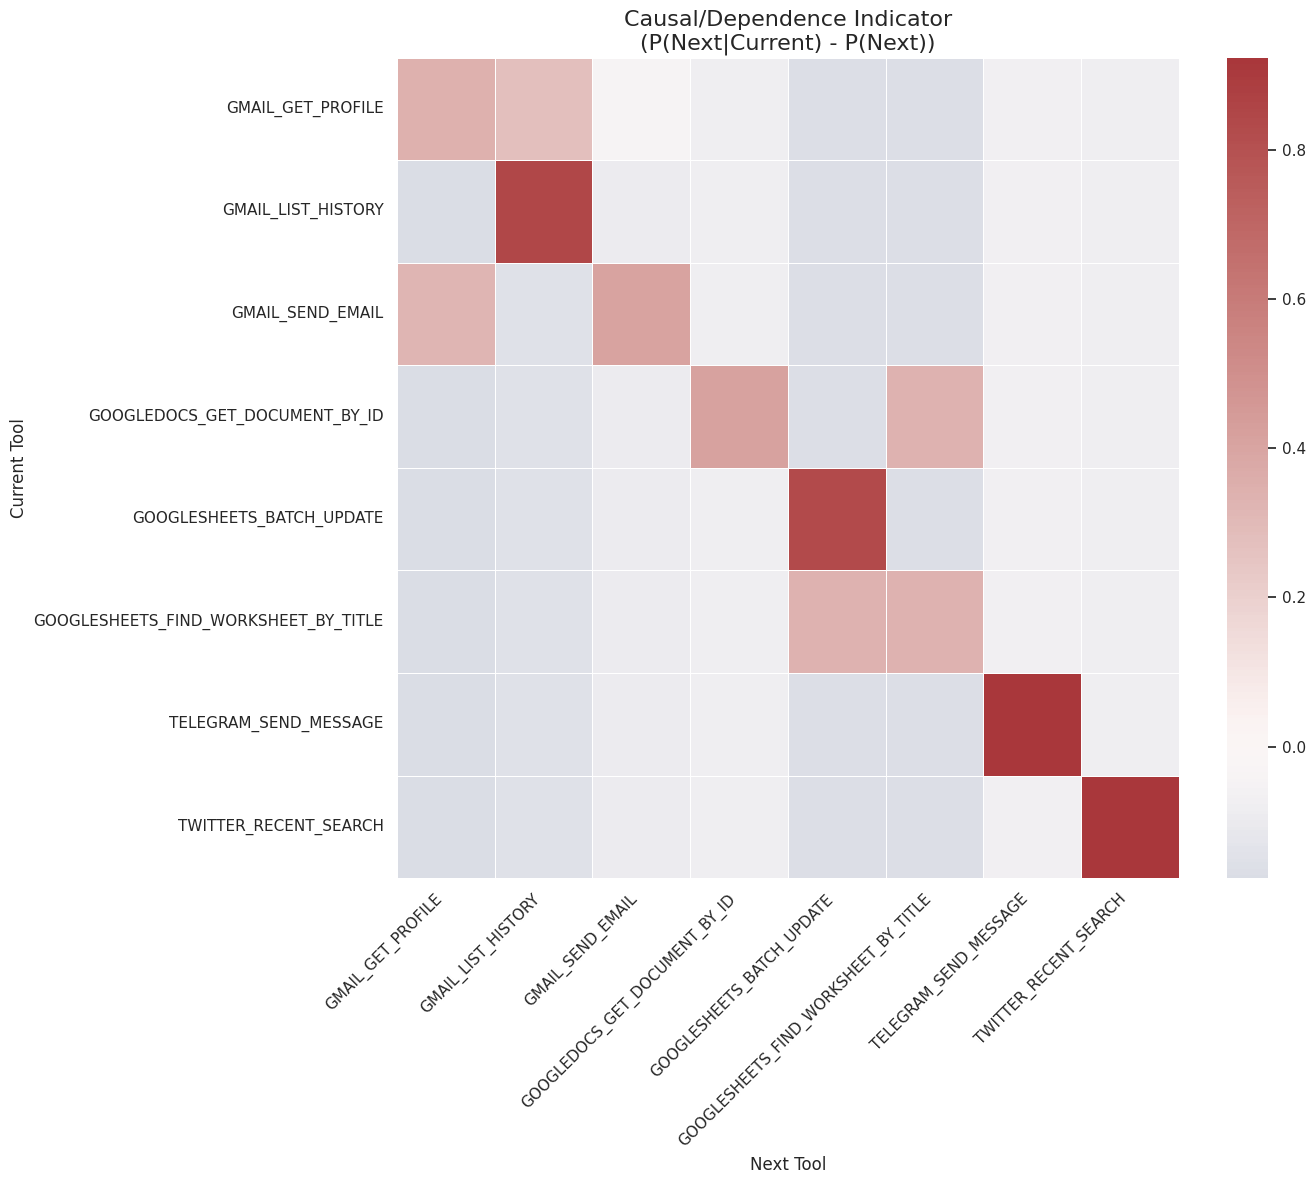


=== Conditional Independence Analysis ===
Max positive deviation: 0.924
Max negative deviation: -0.176
Mean absolute deviation: 0.197

Strong Dependencies (|D| > 0.3):
  GMAIL_GET_PROFILE -> GMAIL_GET_PROFILE: 0.347
  GMAIL_LIST_HISTORY -> GMAIL_LIST_HISTORY: 0.849
  GMAIL_SEND_EMAIL -> GMAIL_GET_PROFILE: 0.324
  GMAIL_SEND_EMAIL -> GMAIL_SEND_EMAIL: 0.408
  GOOGLEDOCS_GET_DOCUMENT_BY_ID -> GOOGLEDOCS_GET_DOCUMENT_BY_ID: 0.416
  GOOGLEDOCS_GET_DOCUMENT_BY_ID -> GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE: 0.332
  GOOGLESHEETS_BATCH_UPDATE -> GOOGLESHEETS_BATCH_UPDATE: 0.832
  GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE -> GOOGLESHEETS_BATCH_UPDATE: 0.332
  GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE -> GOOGLESHEETS_FIND_WORKSHEET_BY_TITLE: 0.332
  TELEGRAM_SEND_MESSAGE -> TELEGRAM_SEND_MESSAGE: 0.924
  TWITTER_RECENT_SEARCH -> TWITTER_RECENT_SEARCH: 0.916


In [13]:
# 5. Conditional Independence Analysis
# Visualize Deviance from Independence: P(Next|Current) - P(Next)

if trans_mat is not None and tool_sequences:
    # Compute Marginal Probabilities P(Next)
    all_next_tools = [trace[i+1] for trace in tool_sequences for i in range(len(trace)-1)]
    total_transitions = len(all_next_tools)
    
    if total_transitions > 0:
        next_counts = Counter(all_next_tools)
        marginal_probs = np.array([next_counts.get(t, 0) / total_transitions for t in tools])
        
        # Difference Matrix
        diff_matrix = trans_mat - marginal_probs.reshape(1, -1)
        
        plt.figure(figsize=(14, 12))
        sns.heatmap(
            diff_matrix, 
            xticklabels=tools, 
            yticklabels=tools, 
            cmap="vlag", 
            center=0, 
            annot=False, 
            linewidths=.5
        )
        
        plt.title('Causal/Dependence Indicator\n(P(Next|Current) - P(Next))', fontsize=16)
        plt.xlabel('Next Tool', fontsize=12)
        plt.ylabel('Current Tool', fontsize=12)
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
        
        # Statistical Summary
        print("\n=== Conditional Independence Analysis ===")
        print(f"Max positive deviation: {diff_matrix.max():.3f}")
        print(f"Max negative deviation: {diff_matrix.min():.3f}")
        print(f"Mean absolute deviation: {np.abs(diff_matrix).mean():.3f}")
        
        # Find strongest dependencies
        strong_deps = np.where(np.abs(diff_matrix) > 0.3)
        if len(strong_deps[0]) > 0:
            print("\nStrong Dependencies (|D| > 0.3):")
            for i, j in zip(strong_deps[0], strong_deps[1]):
                print(f"  {tools[i]} -> {tools[j]}: {diff_matrix[i, j]:.3f}")
else:
    print("Cannot compute conditional independence: missing transition matrix or sequences.")
